In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_205647/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


2024-02-26 12:22:22.637936: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 12:22:22.672952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 12:22:22.672977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 12:22:22.673838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 12:22:22.679466: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all_3_6=data_all[data_all['COT']<3.6]
data_all_10=data_all[data_all['COT']<10]
data_all_25=data_all[data_all['COT']<25]

#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [4]:
print("Number of data points for 3.6 limit: "+str(len(data_all_3_6)))
print("Number of data points for 10 limit: "+str(len(data_all_10)))
print("Number of data points for 25 limit: "+str(len(data_all_25)))
print("Number of data points for no limit: "+str(len(data_all)))

Number of data points for 3.6 limit: 21786
Number of data points for 10 limit: 53156
Number of data points for 25 limit: 102006
Number of data points for no limit: 150000


In [5]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X_3_6=data_all_3_6[X_labels]
y_3_6=data_all_3_6[y_labels]

X_10=data_all_10[X_labels]
y_10=data_all_10[y_labels]

X_25=data_all_25[X_labels]
y_25=data_all_25[y_labels]

X=df[X_labels]
y=df[y_labels]

X_train_3_6, X_test_3_6, y_train_3_6, y_test_3_6=train_test_split(X_3_6,y_3_6,test_size=0.05)
X_train_10, X_test_10, y_train_10, y_test_10=train_test_split(X_10,y_10,test_size=0.05)
X_train_25, X_test_25, y_train_25, y_test_25=train_test_split(X_25,y_25,test_size=0.05)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [6]:
import random

val_size=0.05
validation_indices_3_6=np.array(random.sample(range(len(X_train_3_6['Cloud_B02'])), int(len(X_train_3_6['Cloud_B02'])*val_size)))
train_indices_3_6=[i for i in range(len(X_train_3_6['Cloud_B02'])) if np.any(validation_indices_3_6==i)==False]

validation_indices_10=np.array(random.sample(range(len(X_train_10['Cloud_B02'])), int(len(X_train_10['Cloud_B02'])*val_size)))
train_indices_10=[i for i in range(len(X_train_10['Cloud_B02'])) if np.any(validation_indices_10==i)==False]

validation_indices_25=np.array(random.sample(range(len(X_train_25['Cloud_B02'])), int(len(X_train_25['Cloud_B02'])*val_size)))
train_indices_25=[i for i in range(len(X_train_25['Cloud_B02'])) if np.any(validation_indices_25==i)==False]

validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]



Best model out of total max epochs found at epoch 286
Model all saved...


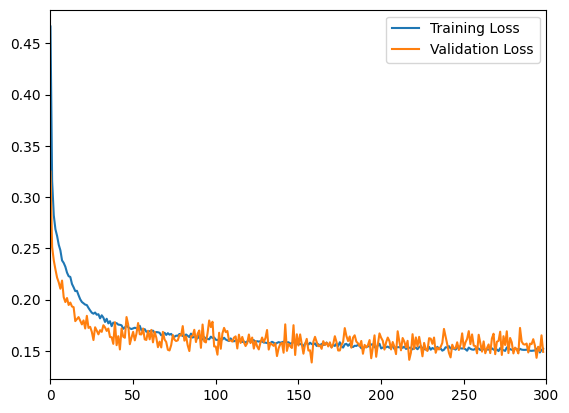

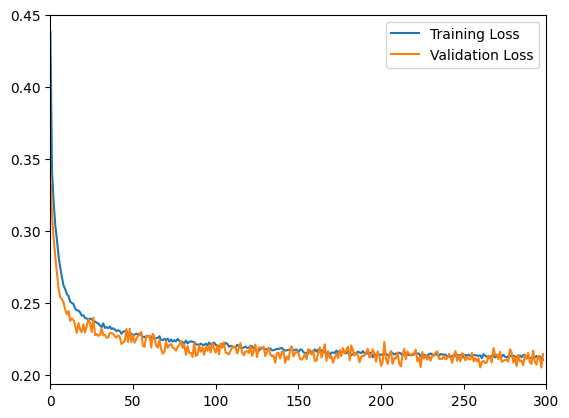

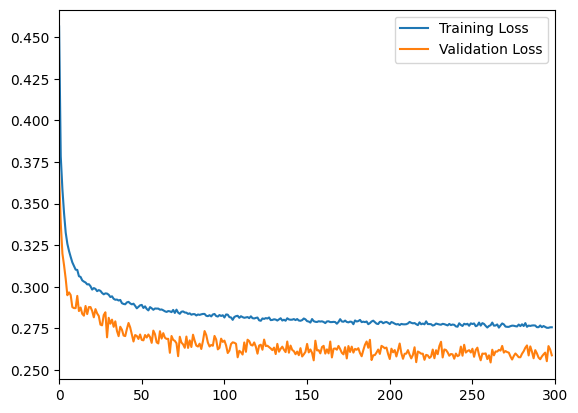

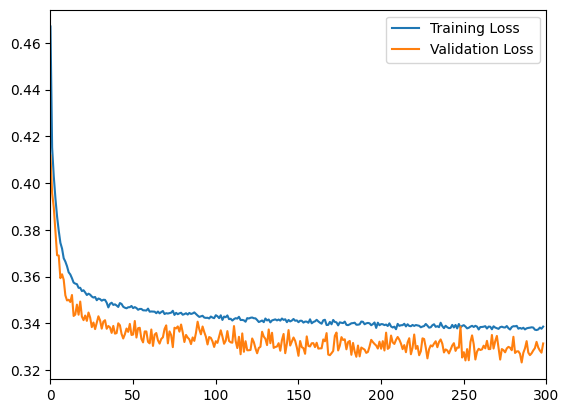

In [7]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500

nepochs=300
model_3_6=QuantileNetwork(quantiles=quantiles)
model_10=QuantileNetwork(quantiles=quantiles)
model_25=QuantileNetwork(quantiles=quantiles)
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes=64
sequence=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes,n_nodes),
    nn.ReLU(),
    nn.Linear(n_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

model_3_6.fit(X_train_3_6.to_numpy(),y_train_3_6.to_numpy(), 
          train_indices_3_6, 
          validation_indices_3_6, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)
hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/3_6',model=model_3_6,X_test=X_test_3_6,y_test=y_test_3_6)
print("Model 3.6 saved...")

model_10.fit(X_train_10.to_numpy(),y_train_10.to_numpy(), 
          train_indices_10, 
          validation_indices_10, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)
hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/10',model=model_10,X_test=X_test_10,y_test=y_test_10)
print("Model 10 saved...")

model_25.fit(X_train_25.to_numpy(),y_train_25.to_numpy(), 
          train_indices_25, 
          validation_indices_25, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)
hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/25',model=model_25,X_test=X_test_25,y_test=y_test_25)
print("Model 25 saved...")

model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)
hf.save_model_and_test_data(filepath='pytorch_models/test_COT_limits/all',model=model,X_test=X_test,y_test=y_test)
print("Model all saved...")

In [8]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [9]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Quant_rate: "+str(quant_rate))
print("R2 score: "+str(r2))

MSE: 0.013140108558053476
PSNR: 18.695808337839672
Quant_rate: [0.0948     0.48786667 0.926     ]
R2 score: 0.6207526678274958


## Load trained models and Visualise

In [6]:
#Load models
model_3_6,X_test_3_6,y_test_3_6=hf.load_model_and_test_data('pytorch_models/test_COT_limits/3_6')
model_10,X_test_10,y_test_10=hf.load_model_and_test_data('pytorch_models/test_COT_limits/10')
model_25,X_test_25,y_test_25=hf.load_model_and_test_data('pytorch_models/test_COT_limits/25')
model,X_test,y_test=hf.load_model_and_test_data('pytorch_models/test_COT_limits/all')

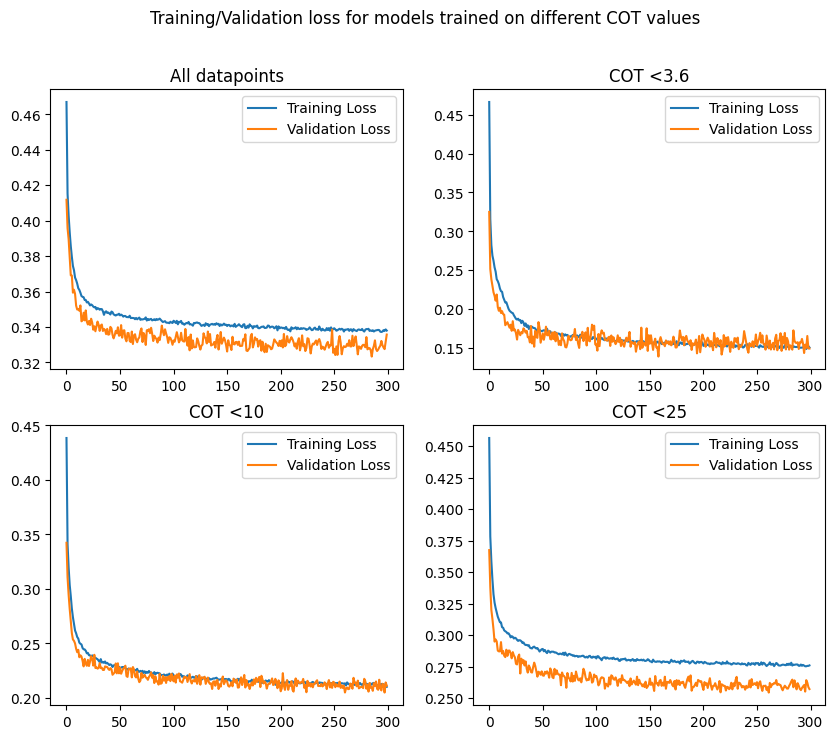

In [7]:
plt.rcParams["figure.figsize"] = [10, 8]
fig, ax =plt.subplots(nrows=2,ncols=2)
fig.suptitle("Training/Validation loss for models trained on different COT values")

ax[0,0].plot(model.train_loss.data.cpu().numpy())
ax[0,0].plot(model.val_loss.data.cpu().numpy())
ax[0,0].set_title("All datapoints")
ax[0,0].legend(['Training Loss','Validation Loss'])

ax[0,1].plot(model_3_6.train_loss.data.cpu().numpy())
ax[0,1].plot(model_3_6.val_loss.data.cpu().numpy())
ax[0,1].set_title("COT <3.6")
ax[0,1].legend(['Training Loss','Validation Loss'])

ax[1,0].plot(model_10.train_loss.data.cpu().numpy())
ax[1,0].plot(model_10.val_loss.data.cpu().numpy())
ax[1,0].set_title("COT <10")
ax[1,0].legend(['Training Loss','Validation Loss'])

ax[1,1].plot(model_25.train_loss.data.cpu().numpy())
ax[1,1].plot(model_25.val_loss.data.cpu().numpy())
ax[1,1].set_title("COT <25")
ax[1,1].legend(['Training Loss','Validation Loss'])

In [8]:
#Make predictions
y_preds_all=model.predict(X_test.to_numpy())
y_preds_3_6=model.predict(X_test_3_6.to_numpy())
y_preds_10=model.predict(X_test_10.to_numpy())
y_preds_25=model.predict(X_test_25.to_numpy())

In [9]:
## Calculate residuals
y_all=y_test.to_numpy()[:,0]
y_pred_all=y_preds_all[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=y_test_3_6.to_numpy()[:,0]
y_pred_3_6=y_preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

y_10=y_test_10.to_numpy()[:,0]
y_pred_10=y_preds_10[:,0,:]
res_10=y_10-y_pred_10[:,1]

y_25=y_test_25.to_numpy()[:,0]
y_pred_25=y_preds_25[:,0,:]
res_25=y_25-y_pred_25[:,1]


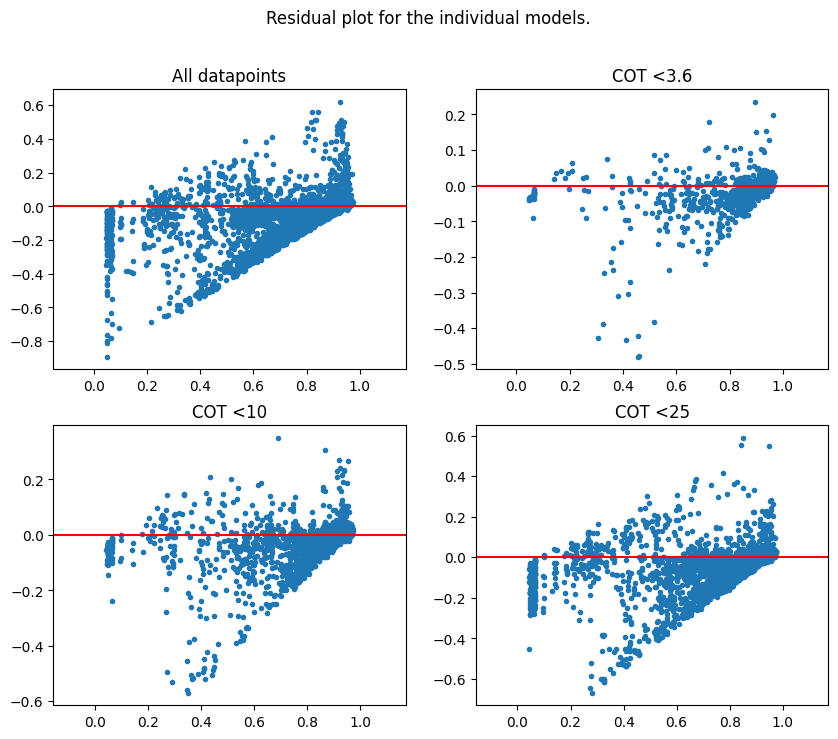

In [10]:
#Plot residuals
fig, ax =plt.subplots(nrows=2,ncols=2)
fig.suptitle("Residual plot for the individual models.")

ax[0,0].plot(y_all,res_all,'.')
ax[0,0].set_title("All datapoints")
ax[0,0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0,0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[0,1].plot(y_3_6,res_3_6,'.')
ax[0,1].set_title("COT <3.6")
ax[0,1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0,1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

ax[1,0].plot(y_10,res_10,'.')
ax[1,0].set_title("COT <10")
ax[1,0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1,0].set_xlim((np.min(y_10)-0.2,np.max(y_10)+0.2))

ax[1,1].plot(y_25,res_25,'.')
ax[1,1].set_title("COT <25")
ax[1,1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1,1].set_xlim((np.min(y_10)-0.2,np.max(y_10)+0.2))

plt.show()


### Residual comparison model trained on all vs model trained on COT <3.6

In [11]:
df_3_6=data_all[data_all['COT']<3.6]
df_X_3_6=df_3_6[X_labels]
df_y_3_6=df_3_6[y_labels]

preds=model.predict(df_X_3_6.to_numpy())
preds_3_6=model_3_6.predict(df_X_3_6.to_numpy())


In [12]:
#Calculate residuals
y_all=df_y_3_6.to_numpy()[:,0]
y_pred_all=preds[:,0,:]
res_all=y_all-y_pred_all[:,1]

y_3_6=df_y_3_6.to_numpy()[:,0]
y_pred_3_6=preds_3_6[:,0,:]
res_3_6=y_3_6-y_pred_3_6[:,1]

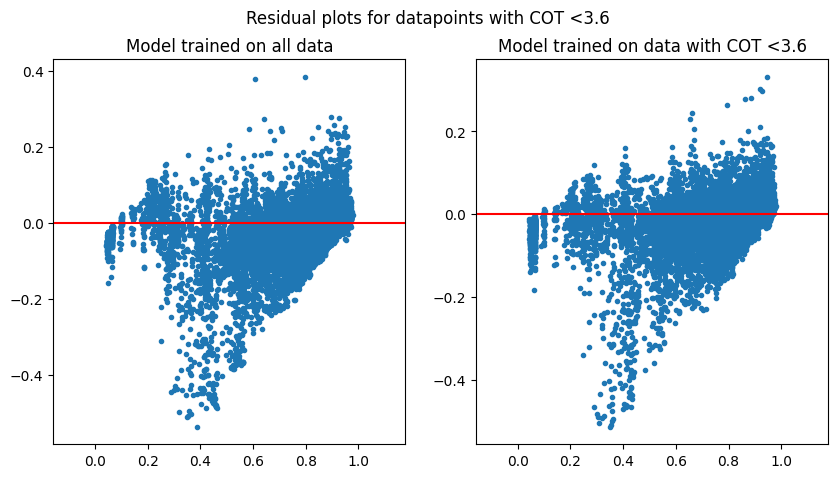

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plots for datapoints with COT <3.6")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Model trained on all data")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_3_6,res_3_6,'.')
ax[1].set_title("Model trained on data with COT <3.6")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_3_6)-0.2,np.max(y_3_6)+0.2))

plt.show()

In [14]:
r2_all=r2_score(df_y_3_6.to_numpy(),preds[:,:,1])
r2_3_6=r2_score(df_y_3_6.to_numpy(),preds_3_6[:,:,1])
mse_all=mean_squared_error(df_y_3_6.to_numpy(),preds[:,:,1])
mse_3_6=mean_squared_error(df_y_3_6.to_numpy(),preds_3_6[:,:,1])
print("R2 score for model trained on all data: "+str(r2_all))
print("R2 score for model trained on data with COT <3.6: "+str(r2_3_6))
print(" ")
print("MSE for model trained on all data: "+str(mse_all))
print("MSE for model trained on data with COT <3.6: "+str(mse_3_6))

R2 score for model trained on all data: 0.9082200978379802
R2 score for model trained on data with COT <3.6: 0.9350260307659132
 
MSE for model trained on all data: 0.003350204096461462
MSE for model trained on data with COT <3.6: 0.002371718129608958


#### Attempt only common test data

In [29]:
X_test_all_3_6=df.iloc[X_test.index][df.iloc[X_test.index]['COT']<3.6]
X_test_all_3_6=X_test_all_3_6[X_labels]

In [30]:
X_test_all_3_6

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Cloud_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle
14755,0.25947,0.19242,0.23273,0.18613,0.29571,0.60494,0.58885,0.60568,0.33111,0.00456,0.43226,0.31138,4.72,81.52,73.24
32973,0.30155,0.30723,0.36904,0.44452,0.51788,0.60221,0.58326,0.74493,0.06190,0.00037,0.86503,0.69259,10.98,52.72,154.68
29833,0.40332,0.40745,0.62579,0.43259,0.87305,1.07157,1.00947,1.08938,0.36381,0.00535,1.00761,0.91241,3.03,34.59,23.48
19386,0.15581,0.13766,0.17417,0.13903,0.23470,0.64583,0.75893,0.81910,0.52781,0.01770,0.46063,0.31919,6.50,59.74,146.90
11000,0.19130,0.17283,0.17460,0.16565,0.17067,0.17704,0.16208,0.17957,0.03143,0.00039,0.15971,0.13005,1.10,40.83,126.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17469,0.24347,0.22582,0.30268,0.20563,0.37615,1.03659,1.03035,1.04349,0.80604,0.10322,0.98045,0.88311,1.42,45.12,116.69
24781,0.23656,0.22371,0.38950,0.20322,0.53067,0.88840,0.85854,0.89811,0.42877,0.01045,0.81508,0.62784,4.15,63.78,105.80
39800,0.89308,0.81879,0.87703,0.88122,0.90292,0.91647,0.88116,0.92826,0.37087,0.00080,0.85025,0.11582,0.55,65.47,158.15
49143,0.30448,0.27694,0.40811,0.24668,0.51004,0.86763,0.77897,0.89291,0.09267,0.00042,0.68697,0.38699,1.50,61.22,94.05
